In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_runtime import SamplerV2 as Sampler

# Syntax for first saving your token.  Delete these lines after saving your credentials.
# QiskitRuntimeService.save_account(channel='ibm_quantum_platform', instance = '<YOUR_IBM_INSTANCE_CRN>', token='<YOUR_API_KEY>', overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum_platform')
 
# Load saved credentials
service = QiskitRuntimeService()

In [3]:
backend=service.least_busy()
print(backend.name)

ibm_torino


In [4]:
sampler=Sampler(mode=backend)


In [5]:
from qiskit.primitives import BackendSamplerV2

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

noise_model=NoiseModel.from_backend(backend)
backend_sim=AerSimulator(noise_model=noise_model)
sampler_sim=BackendSamplerV2(backend=backend_sim)


# You could also define a simulator-based sampler using a generic backend:
# backend_gen = GenericBackendV2(num_qubits=18)
# sampler_gen = BackendSamplerV2(backend=backend_gen)

Almost Deutsch Algo.

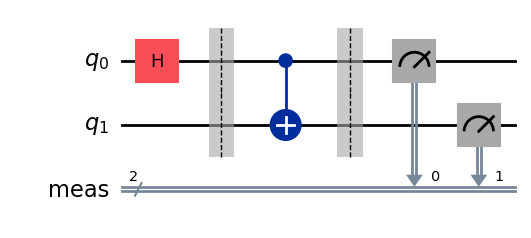

In [53]:
from qiskit import QuantumCircuit

qc=QuantumCircuit(2)

def twobit_function(case: int):
    #Generate a valid two-bit function as a 'Quantum Circuit'
    if case not in [1,2,3,4]:
        raise ValueError("'case' must be in 1, 2, 3, or 4.")
    
    f=QuantumCircuit(2)

    if case in [2,3]:
        f.cx(0,1)
    if case in [3,4]:
        f.x(1)
    return f

# first, convert oracle circuit (above) to a single gate for drawing purposes. otherwise, the circuit is too large to display
blackbox = twobit_function(2).to_gate()  # you may edit the number inside "twobit_function()" to select among the four valid functions
blackbox.label = "$U_f$"


qc.h(0)
qc.barrier()
qc.compose(twobit_function(2), inplace=True)
qc.measure_all()
 
 
qc.draw("mpl")

 : is used to annotate a type but = assigns, running twobit_function() won't give you error if you use :.
 not using any of those still works but running twobit_funciton() will run you into error.



In [54]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm=generate_preset_pass_manager(target=target,optimization_level=3)

qc_isa=pm.run(qc)

In [55]:
#job=sampler.run([qc_isa],shots=1)
job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.meas.get_counts()

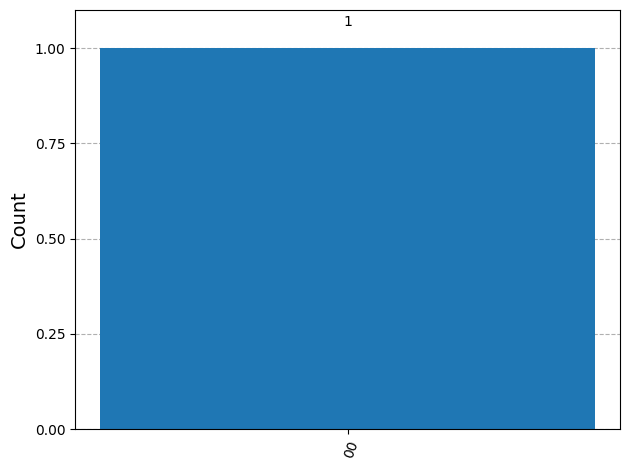

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(counts) # 

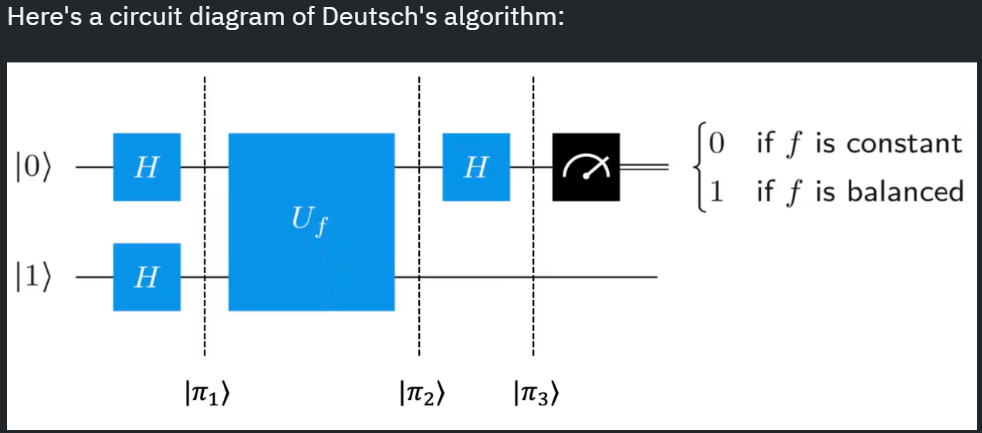

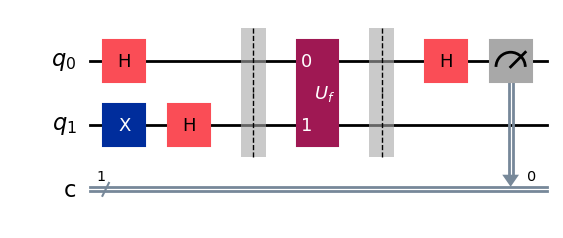

In [57]:
#Deutsch's Algorithm
blackbox=twobit_function(3).to_gate()
blackbox.label="$U_f$"

qc_deutsch=QuantumCircuit(2,1)

qc_deutsch.x(1)
qc_deutsch.h(range(2))
qc_deutsch.barrier()
qc_deutsch.compose(blackbox,inplace=True)
qc_deutsch.barrier()
qc_deutsch.h(0)

qc_deutsch.measure(0,0)

qc_deutsch.draw('mpl')

In [58]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
target=backend.target
pm=generate_preset_pass_manager(target=target,optimization_level=3)

qc_isa=pm.run(qc_deutsch)

In [59]:
#job=sampler.run([qc_isa],shots=1)
job=sampler_sim.run([qc_isa],shots=1)
res=job.result()
counts=res[0].data.c.get_counts()

In [60]:
print(counts)
if "1" in counts:
    print("balanced")
else:
    print("constant")

{'1': 1}
balanced


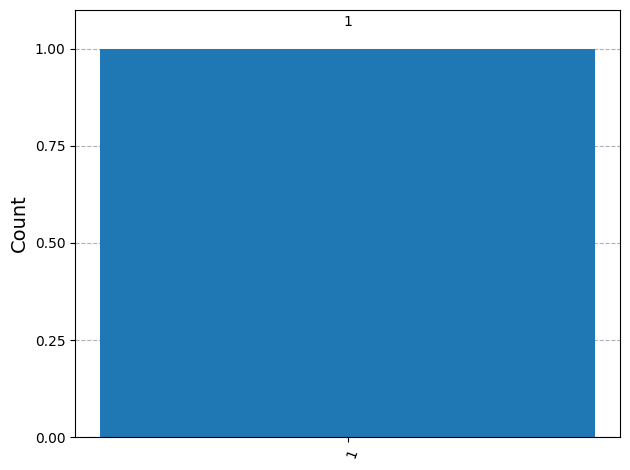

In [61]:
plot_histogram(counts)

# Deutsch-Jozsa Algorithm

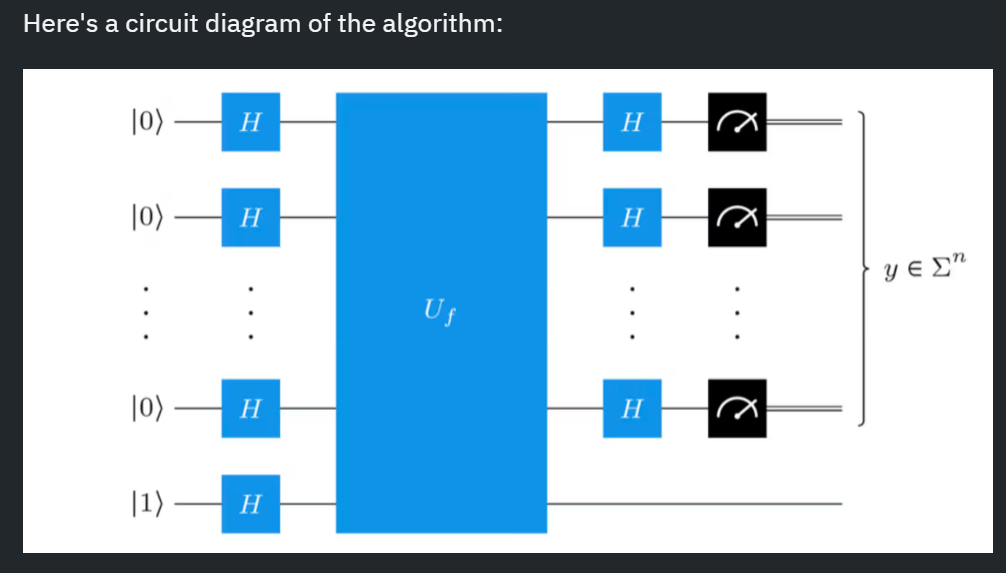

The algorithm will return a bitstring of all 0's if the function is constant, and a bitstring containing at least one 1 if the function is balanced.

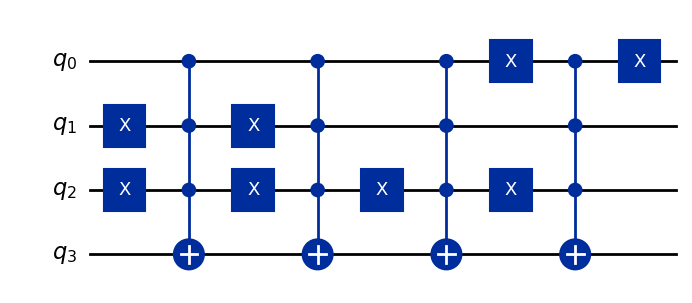

In [2]:
from qiskit import QuantumCircuit
import numpy as np
 
 
def dj_function(num_qubits):
    """
    Create a random Deutsch-Jozsa function.
    """
 
    qc_dj = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubits with 50% chance
        qc_dj.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance.
        return qc_dj 
    # If the "if" statement above was "TRUE" then we've returned the constant
    # function and the function is complete. If not, we proceed in creating our
    # balanced function. Everything below is to produce the balanced function:
 
    # select half of all possible states at random:
    on_states = np.random.choice(  #This is like one of the nCr with replace as False. Else nPr if repalce is True.
        range(2**num_qubits),  # numbers to sample from #where to draw the items
        2**num_qubits // 2,  # number of samples #How many to draw
        replace=False,  # makes sure states are only sampled once  #whether to put the items back again or not.
    )
    
    #print(on_states)
    # for 3 qubits this may look like (2,6,1,8)
 
    def add_cx(qc_dj, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)): # enumerate produces (index, value) pairs.
            if bit == "1":
                qc_dj.x(qubit)
        return qc_dj
 
    for state in on_states:
        #qc_dj.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed. 
        #If you run the following code with barrier it won't run better to comment it off.
        qc_dj = add_cx(qc_dj, f"{state:0b}")  #converts the state to binary.
        qc_dj.mcx(list(range(num_qubits)), num_qubits)
        qc_dj = add_cx(qc_dj, f"{state:0b}")
 
    # qc_dj.barrier()
 
    return qc_dj
 
 
n = 3  # number of input qubits
 
oracle = dj_function(n)
 
display(oracle.draw("mpl"))
# So the following circuit gives out zero for the following bitstrings.

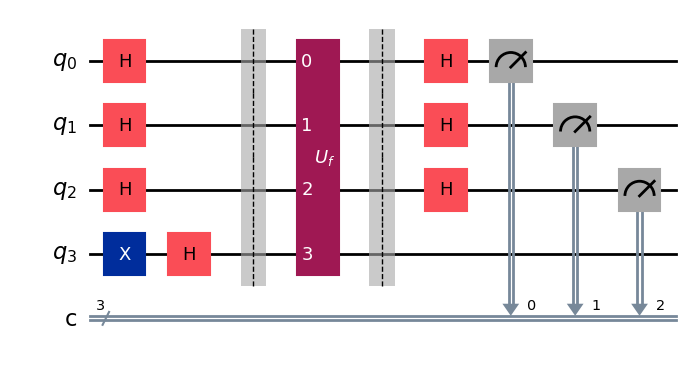

In [12]:
blackbox=oracle.to_gate()
blackbox.label="$U_f$"

qc_dj=QuantumCircuit(n+1,n)
qc_dj.x(n)
qc_dj.h(range(n+1))
qc_dj.barrier()
qc_dj.compose(blackbox,inplace=True)
qc_dj.barrier()
qc_dj.h(range(n))
qc_dj.measure(range(n),range(n))

qc_dj.decompose().decompose()


qc_dj.draw('mpl')


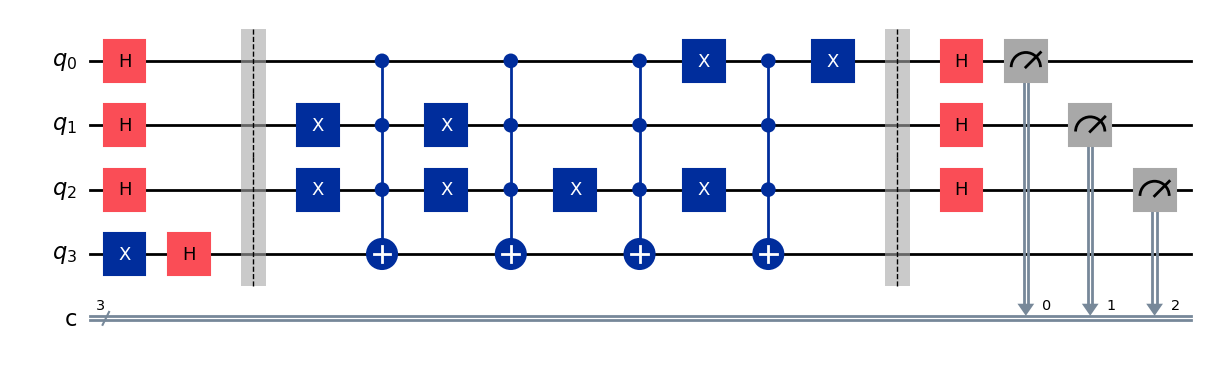

In [10]:
# Step 1: Map the problem
 
qc_dj = QuantumCircuit(n + 1, n)
qc_dj.x(n)
qc_dj.h(range(n + 1))
qc_dj.barrier()
qc_dj.compose(oracle, inplace=True)
qc_dj.barrier()
qc_dj.h(range(n))
qc_dj.measure(range(n), range(n))
 
qc_dj.decompose().decompose()
 
 
qc_dj.draw("mpl")

In [17]:
#Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
target=backend.target
pm=generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa=pm.run(qc_dj)

In [18]:
#job=sampler.run([qc_isa],shots=1)
job=sampler_sim.run([qc_isa],shots=1)
res=job.result()
counts=res[0].data.c.get_counts()

In [19]:
print(counts)



{'101': 1}


In [20]:
if ("0" * n in counts): #0*3=000, checks whether 000 is in dictionary or not.
    print("constant")
else:
    print("balanced")

balanced


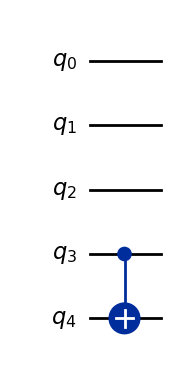

In [16]:
from qiskit import QuantumCircuit
def bv_function(s):
    " create a bv function from a string of 0's and 1's"
    qc=QuantumCircuit(len(s)+1)
    for index, bit in enumerate(reversed(s)):
        if bit=='1':
            qc.cx(index, len(s))

    return qc

display(bv_function("1000").draw('mpl')) #bernstein vazirani outputs a binary sum of secret string and a input

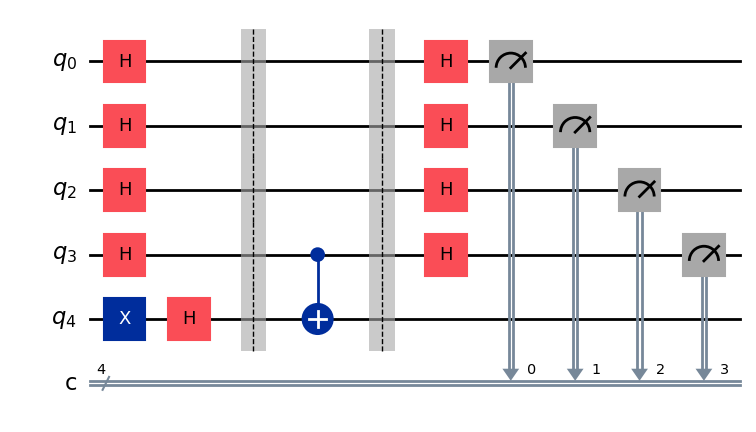

In [17]:
string = "1000"  # secret string that we'll pretend we don't know or have access to
n = len(string)
 
qc = QuantumCircuit(n + 1, n)
qc.x(n)
qc.h(range(n + 1))
qc.barrier()
# qc.compose(oracle, inplace = True)
qc.compose(bv_function(string), inplace=True)
qc.barrier()
qc.h(range(n))
qc.measure(range(n), range(n))
 
qc.draw("mpl")

In [18]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qc)

In [19]:
# Step 3: Run the job on a real quantum computer
 
#job = sampler.run([qc_isa], shots=1)
job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.c.get_counts()

In [20]:
# Step 4: Visualize and analyze results
 
## Analysis
print(counts)

{'1000': 1}
